In [1]:
import pandas as pd
import seaborn as sns; sns.set_theme(font_scale=.75, style="darkgrid")

In [2]:
df = pd.read_csv("data/eurostat_energy_production.tsv", sep="\t") # Load the original data

In [3]:
df.head()

,"freq,nrg_bal,siec,unit,geo\TIME_PERIOD",1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,"A,GEP,BIOE,KTOE,AT",157.782,134.853,145.522,156.582,137.310,131.408,143.406,130.477,141.589,...,399.630,411.008,423.116,423.886,401.775,396.000,386.423,409.742,393.067,402.688
1,"A,GEP,BIOE,KTOE,BE",27.601,26.999,23.646,30.868,42.648,48.839,51.333,61.995,73.689,...,473.319,462.322,490.679,465.397,444.185,452.672,405.945,425.469,327.287,311.993
2,"A,GEP,BIOE,KTOE,BG",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,23.232,30.405,34.048,135.251,156.562,146.117,222.605,192.914,161.135,147.581
3,"A,GEP,BIOE,KTOE,CY",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,4.406,4.473,4.450,4.892,4.980,5.213,5.154,4.973,4.632,0.000
4,"A,GEP,BIOE,KTOE,CZ",34.824,25.107,42.476,50.496,58.189,45.124,44.935,43.320,42.183,...,411.789,408.885,427.083,415.157,432.645,448.440,463.072,464.864,446.422,462.503


In [4]:
# Rename the long column name for better readability
df = df.rename(columns={"freq,nrg_bal,siec,unit,geo\\TIME_PERIOD": "metadata"})

# Split the metadata column into separate columns
df[["freq", "nrg_bal", "siec", "unit", "geo"]] = df["metadata"].str.split(",", expand=True)

df = df.drop(columns=["metadata"]) # Drop the original metadata column
df = df.drop(columns=["freq", "nrg_bal", "unit"]) # Drop columns that contain the same values and not needed

df.head()


,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2017,2018,2019,2020,2021,2022,2023,2024,siec,geo
0,157.782,134.853,145.522,156.582,137.310,131.408,143.406,130.477,141.589,164.445,...,423.116,423.886,401.775,396.000,386.423,409.742,393.067,402.688,BIOE,AT
1,27.601,26.999,23.646,30.868,42.648,48.839,51.333,61.995,73.689,89.242,...,490.679,465.397,444.185,452.672,405.945,425.469,327.287,311.993,BIOE,BE
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,34.048,135.251,156.562,146.117,222.605,192.914,161.135,147.581,BIOE,BG
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,4.450,4.892,4.980,5.213,5.154,4.973,4.632,0.000,BIOE,CY
4,34.824,25.107,42.476,50.496,58.189,45.124,44.935,43.320,42.183,61.339,...,427.083,415.157,432.645,448.440,463.072,464.864,446.422,462.503,BIOE,CZ


In [5]:
df_long = df.melt(id_vars=["siec", "geo"], var_name="year", value_name="electricity_ktoe") # Convert to long format
df_long = df_long.rename(columns={"geo": "country_code", "siec": "energy_code"}) # Rename columns for clarity

df_long["year"] = df_long["year"].astype(int) # Clean year column to integer
df_long["electricity_ktoe"] = pd.to_numeric(df_long["electricity_ktoe"], errors="coerce")
df_long = df_long.dropna(subset=["electricity_ktoe"]) # Drop rows with missing values in the 'electricity_ktoe' column

df_long

,energy_code,country_code,year,electricity_ktoe
0,BIOE,AT,1995,157.782
1,BIOE,BE,1995,27.601
2,BIOE,BG,1995,0.000
3,BIOE,CY,1995,0.000
4,BIOE,CZ,1995,34.824
...,...,...,...,...
9505,TOTAL,PT,2024,4392.902
9506,TOTAL,RO,2024,4589.512
9507,TOTAL,SE,2024,14820.894
9508,TOTAL,SI,2024,1461.108


In [6]:
EU27_codes = ["AT","BE","BG","CY","CZ","DE","DK","EE","EL","ES","FI","FR","HR","HU","IE","IT","LT","LU","LV","MT","NL","PL","PT","RO","SE","SI","SK"]

In [7]:
eu_avg = (df_long[df_long["country_code"].isin(EU27_codes)].groupby(["energy_code", "year"], as_index=False)["electricity_ktoe"].mean())
eu_avg["country_code"] = "EU27_AVG" # Add a new country code for EU27 average

df_long = pd.concat([df_long, eu_avg], ignore_index=True) # Append the EU27 average data to the main dataframe

In [8]:
country_name = {"AT": "Austria", "BE": "Belgium", "BG": "Bulgaria", "CY": "Cyprus", "CZ": "Czechia", "DE": "Germany", "DK": "Denmark",
                "EE": "Estonia", "EL": "Greece", "ES": "Spain", "FI": "Finland", "FR": "France", "HR": "Croatia", "HU": "Hungary",
                "IE": "Ireland", "IT": "Italy", "LT": "Lithuania", "LU": "Luxembourg", "LV": "Latvia", "MT": "Malta", "NL": "Netherlands",
                "NO": "Norway", "PL": "Poland", "PT": "Portugal", "RO": "Romania", "SE": "Sweden", "SI": "Slovenia", "SK": "Slovakia",
                "EU27_2020": "EU27 (total of EU)", "EU27_AVG": "EU27 (average of EU)"}

df_long["country"] = df_long["country_code"].map(country_name).fillna(df_long["country_code"]) # Map country codes to country names

df_long

,energy_code,country_code,year,electricity_ktoe,country
0,BIOE,AT,1995,157.782000,Austria
1,BIOE,BE,1995,27.601000,Belgium
2,BIOE,BG,1995,0.000000,Bulgaria
3,BIOE,CY,1995,0.000000,Cyprus
4,BIOE,CZ,1995,34.824000,Czechia
...,...,...,...,...,...
9824,TOTAL,EU27_AVG,2020,8885.689148,EU27 (average of EU)
9825,TOTAL,EU27_AVG,2021,9287.667852,EU27 (average of EU)
9826,TOTAL,EU27_AVG,2022,8992.097148,EU27 (average of EU)
9827,TOTAL,EU27_AVG,2023,8792.537926,EU27 (average of EU)


Each row represents annual gross electricity production from a renewable source, measured in ktoe.

In [9]:
energy_name = {
    "TOTAL": "All energy sources",
    "BIOE": "Bioenergy",
    "RA000": "Renewables (total)",
    "RA100": "Hydropower",
    "RA300": "Wind power",
    "RA410": "Solar photovoltaic",
    "RA420": "Solar thermal",
    "RA500": "Other renewables",
    "N900H": "Heat pumps (renewable)",
    "FE": "Final energy consumption (context)",
    "C0000X0350-0370": "Other / combined category"
}
df_long["energy_source"] = df_long["energy_code"].map(energy_name).fillna(df_long["energy_code"]) # Map energy codes to energy source names

df_long

,energy_code,country_code,year,electricity_ktoe,country,energy_source
0,BIOE,AT,1995,157.782000,Austria,Bioenergy
1,BIOE,BE,1995,27.601000,Belgium,Bioenergy
2,BIOE,BG,1995,0.000000,Bulgaria,Bioenergy
3,BIOE,CY,1995,0.000000,Cyprus,Bioenergy
4,BIOE,CZ,1995,34.824000,Czechia,Bioenergy
...,...,...,...,...,...,...
9824,TOTAL,EU27_AVG,2020,8885.689148,EU27 (average of EU),All energy sources
9825,TOTAL,EU27_AVG,2021,9287.667852,EU27 (average of EU),All energy sources
9826,TOTAL,EU27_AVG,2022,8992.097148,EU27 (average of EU),All energy sources
9827,TOTAL,EU27_AVG,2023,8792.537926,EU27 (average of EU),All energy sources


In [10]:
swe = df_long[df_long["country"] == "Sweden"] # Filter data for Sweden and EU total to use for diagram example
eu27_total = df_long[df_long["country"] == "EU27 (total of EU)"]

eu27_total

,energy_code,country_code,year,electricity_ktoe,country,energy_source
38,C0000X0350-0370,EU27_2020,1995,66715.909,EU27 (total of EU),Other / combined category
95,N900H,EU27_2020,1995,68087.449,EU27 (total of EU),Heat pumps (renewable)
124,RA000,EU27_2020,1995,30330.063,EU27 (total of EU),Renewables (total)
153,RA100,EU27_2020,1995,27964.978,EU27 (total of EU),Hydropower
182,RA300,EU27_2020,1995,316.179,EU27 (total of EU),Wind power
...,...,...,...,...,...,...
9369,RA300,EU27_2020,2024,42118.286,EU27 (total of EU),Wind power
9397,RA410,EU27_2020,2024,390.372,EU27 (total of EU),Solar photovoltaic
9425,RA420,EU27_2020,2024,26007.449,EU27 (total of EU),Solar thermal
9453,RA500,EU27_2020,2024,40.224,EU27 (total of EU),Other renewables


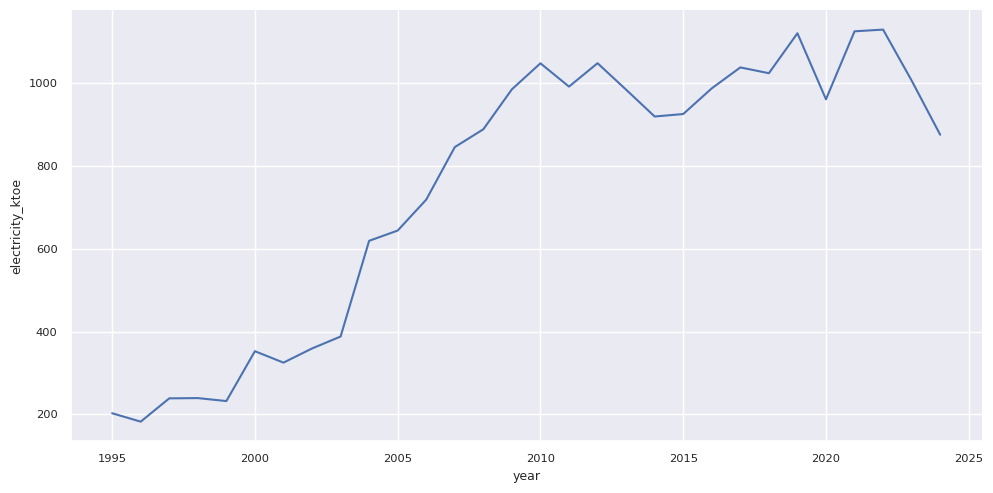

In [11]:
# Example diagram: Bioenergy production in Sweden over time
sns.relplot(data=swe[swe.energy_code == "BIOE"], x="year", y="electricity_ktoe", kind="line", aspect=2)

In [12]:
df_long[df_long["country_code"] == "EU27_AVG"].head()

,energy_code,country_code,year,electricity_ktoe,country,energy_source
9499,BIOE,EU27_AVG,1995,63.084037,EU27 (average of EU),Bioenergy
9500,BIOE,EU27_AVG,1996,61.839556,EU27 (average of EU),Bioenergy
9501,BIOE,EU27_AVG,1997,75.737815,EU27 (average of EU),Bioenergy
9502,BIOE,EU27_AVG,1998,84.379852,EU27 (average of EU),Bioenergy
9503,BIOE,EU27_AVG,1999,86.329000,EU27 (average of EU),Bioenergy


In [40]:
df_long.to_csv("data/tidy_energy.csv", index=False) # Export the tidy data to a CSV file

-----------------------------------------------------------------------------------------

Code below is my experiment with the code.

In [13]:
df_long["country_code"].unique()

array(['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES', 'FI',
       'FR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'NO',
       'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'EU27_2020', 'EU27_AVG'],
      dtype=object)

In [14]:
df_long["energy_code"].unique()

array(['BIOE', 'C0000X0350-0370', 'FE', 'N900H', 'RA000', 'RA100',
       'RA300', 'RA410', 'RA420', 'RA500', 'TOTAL'], dtype=object)

In [15]:
# Practice pivot table

r = pd.DataFrame({
    "year": [2020, 2020, 2021],
    "energy_source": ["Wind power", "Bioenergy", "Wind power"],
    "electricity_ktoe": [100, 200, 120]
})

pivot = r.pivot_table(index="year", columns="energy_source", values="electricity_ktoe", aggfunc="sum").fillna(0)
print(pivot)

energy_source  Bioenergy  Wind power
year                                
2020               200.0       100.0
2021                 0.0       120.0


In [16]:
import sys
sys.path.append("..") # Add the parent directory to the system path

from src.data_functions import load_tidy_energy, renewables_over_time, renewables_share, renewables_boxplot, renewables_vs_nonrenewables_bar, top10_renewable_share, top10_renewable_share_bar

In [17]:
df = load_tidy_energy()

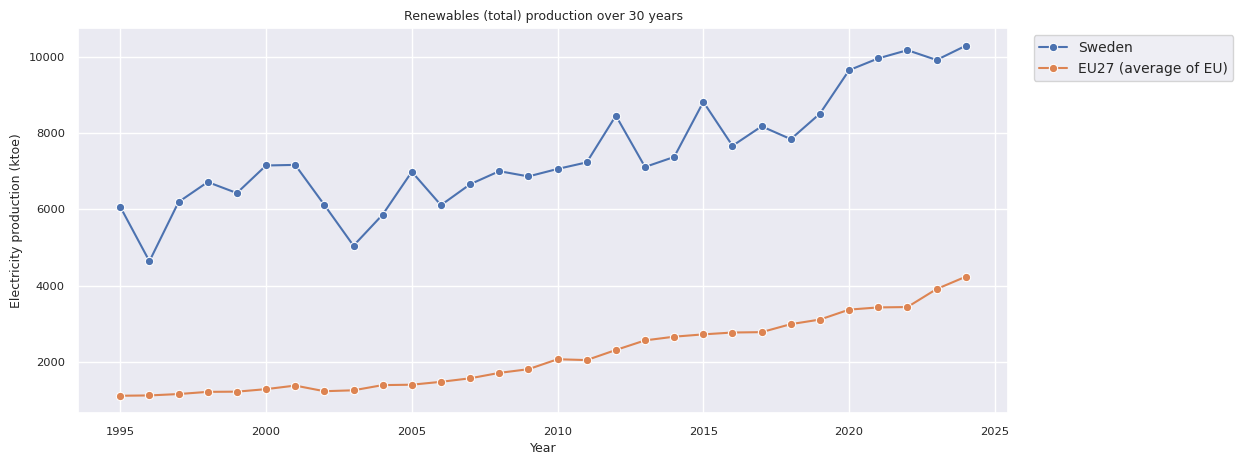

In [18]:
# Example diagram: Renewables (total) production in Sweden vs EU27 average over time
filtered = df_long[(df_long["energy_source"] == "Renewables (total)") & (df_long["country"].isin(["Sweden", "EU27 (average of EU)"]))]

fig = renewables_over_time(filtered, "Renewables (total)")

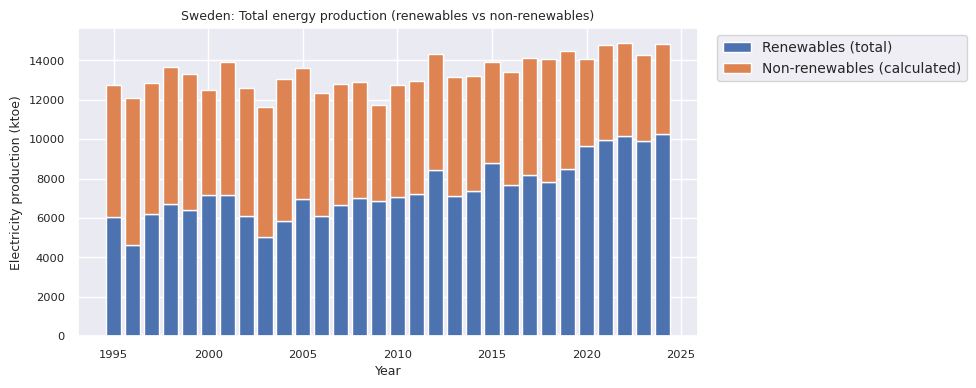

In [19]:
# Example diagram: Share of renewables vs total energy production in EU27 average
fig = renewables_vs_nonrenewables_bar(df_long, "Sweden")

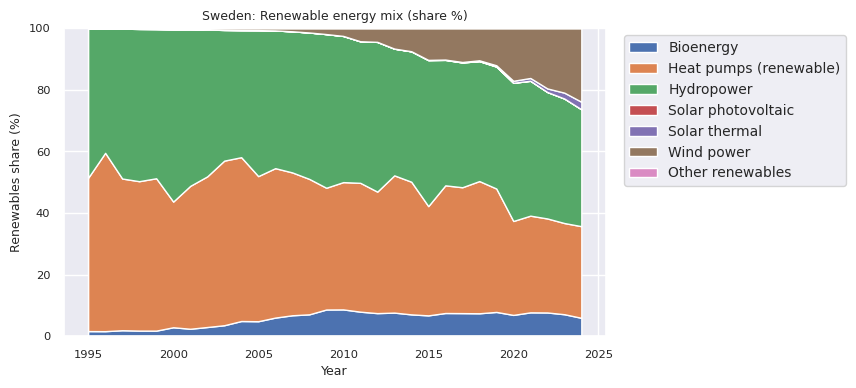

In [20]:
# Example diagram: Share of renewables vs total energy production in Sweden
fig = renewables_share(df_long, "Sweden")

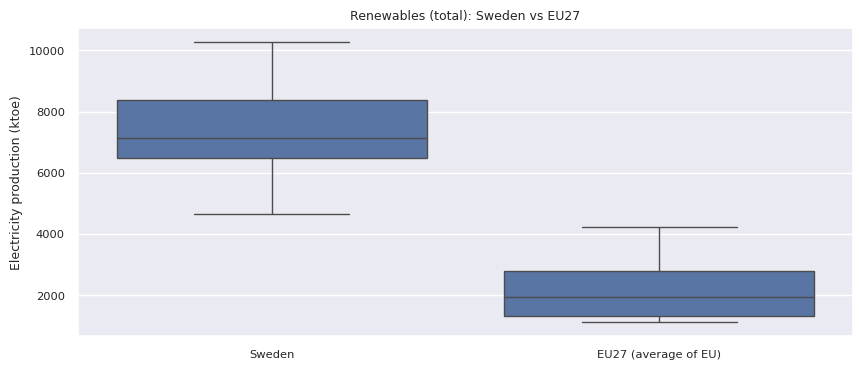

In [21]:
# Example diagram: Boxplot of renewables (total) production across countries
fig = renewables_boxplot(df, "Renewables (total)")

In [24]:
top10 = top10_renewable_share(df, year=2024)
top10

,country,renewable_share
0,Denmark,88.932960
1,Austria,82.248990
2,Portugal,78.985395
3,Lithuania,77.373674
4,Latvia,73.437756
5,Croatia,72.503136
6,Sweden,69.373892
7,Germany,56.305824
8,Finland,56.129384
9,Spain,55.913567


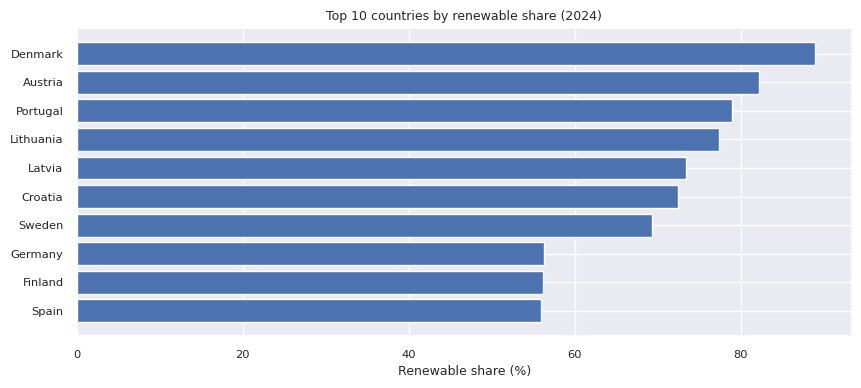

In [23]:
fig = top10_renewable_share_bar(top10, year=2024)

* source /home/marina/data_science/.venv/bin/activate
* streamlit run streamlit_app.py